In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import logging
import gensim
import sys

from collections import OrderedDict
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm

sys.path.insert(0, '../helper_functions/')
from nlp_preprocessing import (clean_string_fields, get_top_n_grams, get_word_frequency_table)

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', 
                    datefmt='%Y-%d-%m',
                    level=logging.INFO)

# paths
root_path = '../data_cleaned/'
data_path = f'{root_path}/biorxiv_clean.csv'

In [2]:
df = pd.read_csv(root_path + data_path)

In [5]:
for col in ['abstract', 'title']: # 'text', 'bibliography'
    df[col] = df[col].fillna('unknown').apply(clean_string_fields)

In [4]:
freq_table = get_word_frequency_table(df['title'], freq_count=2)

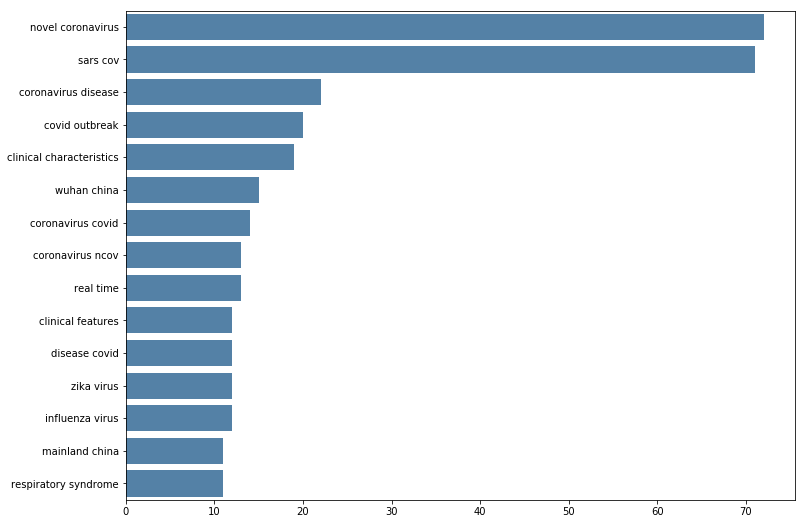

In [5]:
top_n_tri_grams = get_top_n_grams(df['title'], n_count=2)[:15]

x, y = map(list, zip(*top_n_tri_grams))
fig, ax = plt.subplots(figsize=(12,9))
sns.barplot(x = y, y = x, color='steelblue', ax=ax)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

def apply_count_vectorizer(df, series, word_appearal_threshold):
    
    vectorizer = CountVectorizer(max_df=word_appearal_threshold, 
                                 min_df=2, # words that appear in < x lines will be discarded
                                 token_pattern='\w+|\$[\d\.]+|\S+')
    
    tf = vectorizer.fit_transform(df[series]).toarray()

    logging.info(f"applying vectorizer : {vectorizer.get_params()}. \n Matrix shape: {tf.shape}")
    logging.info(f"discard words appearing in more than {word_appearal_threshold}% of cases")
    
    # tf_feature_names tells us what word each column in the matric represents
    tf_feature_names = vectorizer.get_feature_names()
    
    return tf, tf_feature_names

In [23]:
tf, tf_feature_names = apply_count_vectorizer(df=df, series = 'title', word_appearal_threshold=.9)

2020-25-03 : INFO : applying vectorizer : {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 0.9, 'max_features': None, 'min_df': 2, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '\\w+|\\$[\\d\\.]+|\\S+', 'tokenizer': None, 'vocabulary': None}. 
 Matrix shape: (803, 1051)
2020-25-03 : INFO : discard words appearing in more than 0.9% of cases


In [25]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [26]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [27]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,bat,7.0,protein,23.5,coronavirus,58.5,unknown,36.1,cells,16.1,cell,23.3,virus,21.9,covid,79.9,cov,64.6,infectious,17.5
1,vaccine,6.8,rna,17.5,covid,51.8,outbreak,7.8,virus,13.6,rna,13.5,sequencing,14.0,china,54.4,sars,61.2,disease,13.4
2,transmission,6.5,binding,13.1,clinical,47.5,acute,7.8,single,10.4,virus,11.6,rna,12.4,novel,45.0,coronavirus,23.5,global,8.0
3,post,5.1,viral,10.3,patients,40.5,respiratory,7.6,center,9.1,zika,10.0,using,10.4,coronavirus,42.1,novel,23.1,viral,7.7
4,signaling,5.0,virus,10.0,novel,33.2,infect,7.0,infection,9.1,host,9.9,metagenomic,9.7,epidemic,36.9,structure,16.9,transmission,7.1
5,virus,4.3,ncov,9.7,characteristics,28.1,covid,6.8,study,7.9,reveals,8.9,data,9.5,outbreak,28.0,spike,14.0,bronchitis,7.1
6,expression,4.2,analysis,8.7,china,27.8,induced,5.9,influenza,7.6,single,8.7,host,8.8,wuhan,24.1,human,13.6,data,6.9
7,human,4.1,coronavirus,8.2,pneumonia,21.7,social,5.5,covid,7.6,ncov,8.4,respiratory,8.6,transmission,19.9,virus,12.7,covid,6.4
8,specific,4.1,molecular,8.0,analysis,21.4,syndrome,5.2,retrospective,7.1,antiviral,7.9,human,8.5,model,19.3,ncov,11.3,tool,6.1
9,children,4.1,proteins,7.9,cov,16.6,end,5.1,hospital,6.1,expression,7.6,specific,6.9,ncov,19.0,receptor,11.2,diseas,5.1
